# Eligiendo modelos con incertidumbre

> All models are wrong, but some are useful.

George Box

> If you torture the data long enough, it will confess.

Ronald Coase

A esta altura de la maetria, el alumno ya debe saber lo importante que es no sub-ajustar, ni sobre-ajustar un modelo. Puede repasar los conceptos visualmente en el siguiente link http://www.r2d3.us/visual-intro-to-machine-learning-part-2/

Para lograr esto, necesitamos "construir" el mejor modelo posible. Sin embargo, esto nos plantea dos preguntas clave:
* ¿qué significa construir un modelo?
* Y, en segundo lugar, si tenemos dos modelos, ¿cómo determinamos cuál es el mejor?

Empecemos realizando una comparación entre el modelo por defecto  de **árboles de decisión** (no controla el crecimiento) y uno levemente parametrizado.

Levantemos el entorno e instalemos los paquetes que nos probablemente no dispongamos. Se usarán a lo largo de la clase.

In [ ]:
%pip install optuna

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from joblib import Parallel, delayed

from time import time

import optuna
from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history

C:\Users\jgjua\AppData\Local\Temp\ipykernel_47144\3291287683.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Notará a continuación que trabajaremos como mes de entrenamiento **Febrero** y reservaremos **Abril** solo para pruebas

In [2]:
dataset_path = '../datasets/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

# agregue sus semillas
semillas =  [549937, 792991, 886969, 208961, 780587] # [17,19,23,29,31]

data = pd.read_csv(dataset_path + dataset_file)

C:\Users\jgjua\AppData\Local\Temp\ipykernel_47144\2029503624.py:13: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path + dataset_file)


In [4]:
# contar cantidad de datos casos por foto_met y clase_ternaria
data.groupby(['foto_mes','clase_ternaria']).size()

foto_mes  clase_ternaria
202101    BAJA+1               636
          BAJA+2               785
          CONTINUA          160605
202102    BAJA+1               790
          BAJA+2              1017
          CONTINUA          160839
202103    BAJA+1              1023
          BAJA+2               981
          CONTINUA          161681
202104    BAJA+1               987
          BAJA+2              1189
          CONTINUA          161914
dtype: int64

In [5]:
X = data[data['foto_mes'] == mes_train]
y = X['clase_ternaria']
X = X.drop(columns=['clase_ternaria'])

Y necesitamos una función que nos ayude a calcular la ganancia

In [6]:
def ganancia(model, X, y, prop=1, threshold=0.025):

  class_index = np.where(model.classes_ == "BAJA+2")[0][0]
  y_hat = model.predict_proba(X)

  @np.vectorize
  def ganancia_row(predicted, actual, threshold):
    if  predicted >= threshold:
      if actual == "BAJA+2":
        return ganancia_acierto
      else:
        return -costo_estimulo
    else:
      return 0

  # print(y_hat[:,class_index])
  return ganancia_row(y_hat[:,class_index], y, threshold).sum() / prop


Mira a continuación el siguiente código.

* ¿Cuál cree que es el mejor modelo?
* ¿Cuáles son los problemas que ve?

In [7]:
model_base = DecisionTreeClassifier(random_state=semillas[0])
model_ale = DecisionTreeClassifier(#criterion='gini',
                               random_state=semillas[0],
                               min_samples_split=80,
                               max_depth=5)

model_base.fit(X,y)
model_ale.fit(X,y)


DecisionTreeClassifier(max_depth=5, min_samples_split=80, random_state=549937)

In [ ]:
print(f"Ganancia de modelo Base: {ganancia(model_base, X, y)}")
print(f"Ganancia de modelo Ale:  {ganancia(model_ale, X, y)}")

* ¿Cómo se pueden solucionar?

Dado que lo que hicimos no pinta nada bien, pasemos a una de las herramientas que separa la ciencia de datos de la estadística tradicional

* ¿Por qué separamos en train/test?
* ¿Cómo funciona la estadística tradicional?
* Son números aleatorios los que nos dan las computadoras
* ¿Por qué usamos semillas?
* ¿Qué es una partición estratificada?
* ¿Es realmente en nuestro caso una partición estratificada?



Veamos alguna de las formas de separar los conjuntos de datos para medir su calidad:

* **Train-Test Split**: Divide el conjunto de datos en dos partes: un conjunto de entrenamiento y otro de prueba. El conjunto de entrenamiento se utiliza para ajustar el modelo, y el conjunto de prueba para evaluar su rendimiento.

* **K-Fold Cross Validation**: Divide los datos en k subconjuntos o folds. El modelo se entrena k veces, cada vez utilizando k-1 subconjuntos como entrenamiento y el subconjunto restante como prueba. Esto se repite hasta que cada subconjunto se haya utilizado como conjunto de prueba una vez.

* **Shuffle Split** (aka Montecarlo Cross Validation): Genera múltiples particiones aleatorias de los datos en conjuntos de entrenamiento y prueba. A diferencia de K-Fold, no garantiza que todos los puntos de datos sean utilizados en alguna iteración.

En la cátedra preferimos usar está última, pero el alumno es libre de usar la que considera conveniente.

Armemos ahora nuevamente los modelos anteriores, pero utilizando estas particiones:

In [8]:
sss = StratifiedShuffleSplit(n_splits=20,
                             test_size=0.3,
                             random_state=semillas[0])

# Función que paraleliza la construcción de árboles de decisión
def train_and_evaluate(train_index, test_index, params, X, y):
  m = DecisionTreeClassifier()
  m.fit(X.iloc[train_index],y.iloc[train_index])
  # Note que con el parámetro prop se corrige la distorsión por sampleo de la
  # ganancia
  ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
  return m, ganancia_value

modelo_base_param = {"random_state":semillas[0]}

modelo_ale_param = {"criterion": 'gini',
                     "random_state":semillas[0],
                     "min_samples_split":80,
                     "max_depth":5,
}

results_base = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(train_index, test_index, modelo_base_param, X, y)
    for train_index, test_index in sss.split(X, y)
)

results_ale = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(train_index, test_index, modelo_ale_param, X, y)
    for train_index, test_index in sss.split(X, y)
)


Estamos haciendo por cada juego de parámetros 20 modelos. Esto no suele ser lo habitual. Con 5 se puede conseguir buenos resultados.

Vamos a ver que tan bien le fue a los modelos en los conjuntos de prueba:

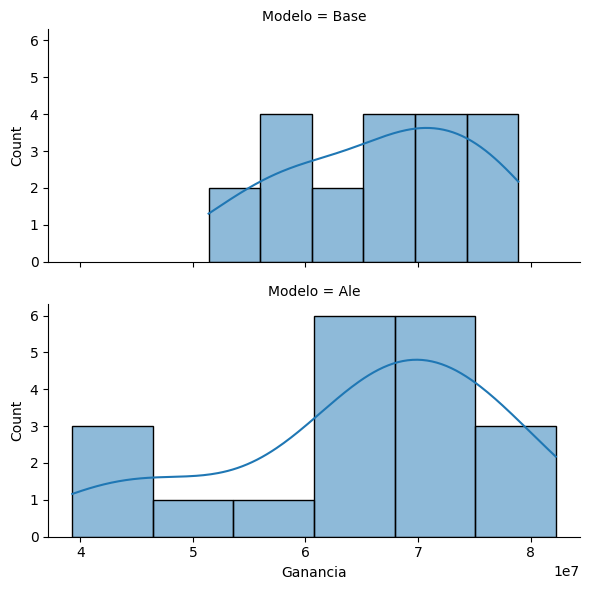

In [9]:
ganancias_modelos_base = [result[1] for result in results_base]
ganancias_modelos_ale = [result[1] for result in results_ale]

df_pred = pd.DataFrame({'Ganancia': [result[1] for result in results_base], 'Modelo': 'Base'})
df_pred2 = pd.DataFrame({'Ganancia': [result[1] for result in results_ale], 'Modelo': 'Ale'})
df_combined = pd.concat([df_pred, df_pred2])

g = sns.FacetGrid(df_combined, row="Modelo", aspect=2)
g.map(sns.histplot, "Ganancia", kde=True)
plt.show()

* ¿Qué tan distintos son de los primero valores calculados con el modelo completo?
* ¿Con cuál se queda?
* ¿Por qué se produce semejante dispersión?
* ¿Cuál considera que es el "valor real"?

Podemos mirar la media

In [10]:
mean_base = df_combined[df_combined['Modelo'] == 'Base']['Ganancia'].mean()
mean_ale = df_combined[df_combined['Modelo'] == 'Ale']['Ganancia'].mean()

print(f"Ganancia media del modelo base: {mean_base}")
print(f"Ganancia media del modelo ale: {mean_ale}")

Ganancia media del modelo base: 66820833.33333333
Ganancia media del modelo ale: 65079000.000000015


In [ ]:
12492666/12275666

* Si no le gusta la media, como más puede elegir un modelo.

> **La vida no es simple**  -- Alumno promedio de la maestría.

Muy interesante, pero lo importante es que sucedería en el **futuro**. Por este motivo nos guardamos el mes de **Abril**.

In [11]:
mes_test

202104

In [12]:
X_futuro = data[data['foto_mes'] == mes_test]
y_futuro = X_futuro['clase_ternaria']
X_futuro = X_futuro.drop(columns=['clase_ternaria'])

Sobre el mes de abril, debemos usar el modelo que se entreno sobre todos los datos

In [13]:
ganancia_junio_base = ganancia(model_base, X_futuro, y_futuro)
ganancia_junio_ale = ganancia(model_ale, X_futuro, y_futuro)

print(f"Ganancia de modelo Base en Junio: {ganancia_junio_base}")
print(f"Ganancia de modelo Ale en Junio: {ganancia_junio_ale}")


Ganancia de modelo Base en Junio: 108031000.0
Ganancia de modelo Ale en Junio: 110089000.0


* ¿Cuál es mejor?
* ¿Por qué cree que el mejor es el mejor?
* ¿Hubiera elegido sabiamente únicamente con los datos de **Febrero**?

El mundo es un lugar **cruel** para los data scientists. El escenario anterior tampoco es el presente para los alumnos. Ya que **kaggle** divide el dataset en una parte **pública** y otra **privada**. Simulemos los efectos que produce en la decisión del mejor modelo en los leaderboards, simulando varios a la vez.


In [14]:
# podemos tomar más muestras, dado que solo vamos a scorear y eso es más rápido
sss_futuro = StratifiedShuffleSplit(n_splits=50,
                             test_size=0.3,
                             random_state=semillas[0])

ganancias_futuro_privada_ale = []
ganancias_futuro_privada_base = []
ganancias_futuro_publica_ale = []
ganancias_futuro_publica_base = []

for train_index, test_index in sss_futuro.split(X_futuro, y_futuro):
  ganancias_futuro_privada_ale.append(ganancia(model_ale, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7))
  ganancias_futuro_privada_base.append(ganancia(model_base, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7))
  ganancias_futuro_publica_ale.append(ganancia(model_ale, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3))
  ganancias_futuro_publica_base.append(ganancia(model_base, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3))


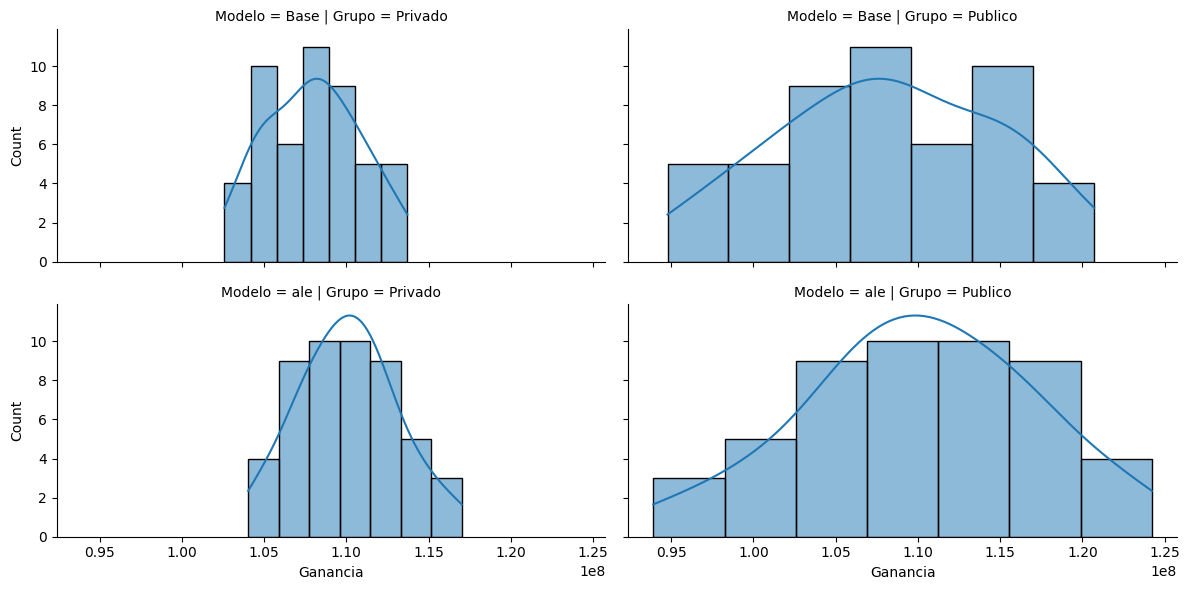

In [15]:
df_pred_1_ale = pd.DataFrame({'Ganancia': ganancias_futuro_privada_ale, 'Modelo': 'ale', 'Grupo': 'Privado'})
df_pred_2_ale = pd.DataFrame({'Ganancia': ganancias_futuro_publica_ale, 'Modelo': 'ale', 'Grupo': 'Publico'})
df_pred_1_base = pd.DataFrame({'Ganancia': ganancias_futuro_privada_base, 'Modelo': 'Base', 'Grupo': 'Privado'})
df_pred_2_base = pd.DataFrame({'Ganancia': ganancias_futuro_publica_base, 'Modelo': 'Base', 'Grupo': 'Publico'})

df_combined = pd.concat([df_pred_1_base, df_pred_2_base, df_pred_1_ale, df_pred_2_ale ])

g = sns.FacetGrid(df_combined, col="Grupo", row="Modelo", aspect=2)
g.map(sns.histplot, "Ganancia", kde=True)
plt.show()


In [16]:
mean_base_privado = df_combined[(df_combined['Modelo'] == 'Base') & (df_combined['Grupo'] == 'Privado')]['Ganancia'].mean()
mean_base_publico = df_combined[(df_combined['Modelo'] == 'Base') & (df_combined['Grupo'] == 'Publico')]['Ganancia'].mean()
mean_ale_privado = df_combined[(df_combined['Modelo'] == 'ale') & (df_combined['Grupo'] == 'Privado')]['Ganancia'].mean()
mean_ale_publico = df_combined[(df_combined['Modelo'] == 'ale') & (df_combined['Grupo'] == 'Publico')]['Ganancia'].mean()

print(f"Ganancia media del modelo base en privado: {mean_base_privado}")
print(f"Ganancia media del modelo base en publico: {mean_base_publico}")
print(f"Ganancia media del modelo ale en privado: {mean_ale_privado}")
print(f"Ganancia media del modelo ale en publico: {mean_ale_publico}")


Ganancia media del modelo base en privado: 107990800.0
Ganancia media del modelo base en publico: 108124800.0
Ganancia media del modelo ale en privado: 110102800.0
Ganancia media del modelo ale en publico: 110056800.00000001


* ¿Que significa todo esto?

Bueno, dos cosas.

* El modelo ale, es un caso de **vagancia**. Cambiar 2 parámetros y esperar un cambio radical no es lo más inteligente que se puede hacer. Realmente hay que hacer un esfuerzo para separar las distribuciones.
* Aún así elegir un modelo no es una tarea simple que se pueda hacer con una **certeza** absoluta.

Para mejorar los modelos, una paso adecuado es la búsqueda de hiperparámetros. Podemos contar con las siguientes técnicas de búsqueda de parámetros:

* **Grid Search**: Explora exhaustivamente todas las combinaciones posibles de hiperparámetros dentro de un conjunto predefinido de valores. Aunque es exhaustivo.

* **Random Search**: En lugar de probar todas las combinaciones posibles, selecciona un número aleatorio de combinaciones de hiperparámetros dentro de un rango predefinido.

* **Bayesian Optimization**: Este método construye un modelo probabilístico del rendimiento de los hiperparámetros y utiliza ese modelo para seleccionar los valores de hiperparámetros más prometedores.

* **Tree-structured Parzen Estimator (TPE)**: Una variante de la optimización bayesiana que utiliza estimadores de densidad basados en árboles (Parzen estimators) para modelar la probabilidad de los hiperparámetros óptimos. Es eficiente en la exploración de espacios de hiperparámetros complejos y se adapta bien a configuraciones con interdependencias entre los parámetros.

* **Genetic Algorithms**: Emplea principios de la evolución natural, como selección, cruce y mutación, para encontrar combinaciones óptimas de hiperparámetros. Es útil en espacios de búsqueda complejos, aunque puede ser computacionalmente costoso.

Repasemos en clase de que se trata cada uno. (tome notas)

Todos nos buenas opciones para la búsqueda de ... nah mentira, **grid search** apesta, si no me cree calcule el tiempo necesario para barrer el dominio de búsqueda.

Para la búsquedas de parámetros usaremos **Optuna**. **Optuna** es una librería poderosa y flexible, diseñada para realizar búsquedas eficientes y automatizadas.

* Utiliza casi todos los álgoritmos mencionados y más.

* Permite definir espacios de búsqueda complejos, incluyendo hiperparámetros categóricos, continuos, discretos y con dependencias condicionales.

* Ofrece un mecanismo de pruning o poda, que permite detener evaluaciones de configuraciones de hiperparámetros que no muestran promesas tempranas.

* Facilidad de Uso y Configuración.

* Proporciona herramientas de visualización integradas para analizar el progreso de la optimización, visualizar la importancia de los hiperparámetros y explorar las configuraciones probadas.

Buscaremos un mejor modelo de manera inteligente:

In [17]:

sss_opt = ShuffleSplit(n_splits=5, test_size=0.3, random_state=semillas[1])

def objective(trial, X, y, sss):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_depth = trial.suggest_int('max_depth', 2, 30)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 60)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 60)

  def train_and_evaluate(train_index, test_index, X, y):
    m = DecisionTreeClassifier(
        criterion= criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        random_state=semillas[0],
    )
    m.fit(X.iloc[train_index],y.iloc[train_index])
    ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
    return ganancia_value

  results = Parallel(n_jobs=-1)(
      delayed(train_and_evaluate)(train_index, test_index, X, y)
      for train_index, test_index in sss.split(X)
  )

  return np.mean(results)



In [19]:
storage_name = "sqlite:///optimization_tree.db"
study_name = "exp_101_decision-tree-opt"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-08-31 11:04:33,939] A new study created in RDB with name: exp_101_decision-tree-opt


Entre la muchas ventajas que tiene **Optuna** es que va almacenando las exploraciones en una base de datos, lo que nos permite continuar la búsqueda si esta se interrumpe.

A continuación veremos como fue el proceso de búsqueda a través de las visualizaciones que cuenta la herramienta (los gráficos son bastante autoexplicativos)

In [20]:
# No quiero que se ejecute automaticamente
study.optimize(lambda trial: objective(trial, X, y, sss_opt), n_trials=200)

[I 2024-08-31 11:06:10,140] Trial 0 finished with value: 70634666.66666667 and parameters: {'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_leaf_nodes': 59}. Best is trial 0 with value: 70634666.66666667.
[I 2024-08-31 11:06:16,125] Trial 1 finished with value: 66378666.66666667 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_leaf_nodes': 4}. Best is trial 0 with value: 70634666.66666667.
[I 2024-08-31 11:06:28,177] Trial 2 finished with value: 71344000.0 and parameters: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_leaf_nodes': 33}. Best is trial 2 with value: 71344000.0.
[I 2024-08-31 11:06:37,226] Trial 3 finished with value: 69720000.0 and parameters: {'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 54, 'min_samples_leaf': 2, 'max_leaf_nodes': 15}. Best is trial 2 with value: 71344000.0.
[I 2024-08-31 11:06:46,836] Trial 4

max depth entre 5 y 10 está ok. max leaf nodes se podria explorar más arriba de 60.

In [ ]:
# optuna.load_study(study_name, storage=storage_name)

In [21]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
                    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
                    123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
                    135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
                    147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
                    159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
                    171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
                    183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
                    195, 196, 197, 198, 199],
              'y': [70634666.66666667, 66378666.66666667, 71344000.0, 69720000.0,
                    70620666.66666667, 68222000.0, 65529333.33333335,
                    65874666.66666667, 66411333.333333336, 68240666.66666667,
                    60727333.333333336, 71306666.66666669, 71227333.33333334,
                    70508666.66666667, 69020000.00000001, 71843333.33333334,
                    74102000.0, 68782000.0, 70018666.66666667, 72002000.0,
                    69846000.0, 69720000.00000001, 71815333.33333334,
                    60727333.333333336, 70634666.66666667, 68782000.0,
                    74162666.66666667, 70140000.0, 68782000.0, 69332666.66666667,
                    71064000.00000001, 71843333.33333334, 70359333.33333334,
                    74102000.0, 71880666.66666667, 70443333.33333334,
                    60727333.333333336, 71792000.0, 70359333.33333334, 68796000.0,
                    69108666.66666666, 71540000.00000001, 71880666.66666667,
                    70975333.33333334, 71563333.33333334, 67470666.66666667,
                    68497333.33333334, 60727333.333333336, 71036000.0,
                    71768666.66666667, 68096000.0, 71880666.66666667,
                    71563333.33333334, 70522666.66666667, 67470666.66666667,
                    68796000.0, 71064000.0, 68782000.0, 71633333.33333334,
                    72767333.33333334, 72767333.33333334, 72767333.33333334,
                    72767333.33333334, 72767333.33333334, 71488666.66666667,
                    72067333.33333334, 70919333.33333334, 74102000.0,
                    73924666.66666667, 71274000.00000001, 71885333.33333334,
                    74102000.0, 72912000.00000001, 72912000.00000001,
                    67512666.66666667, 72828000.00000001, 72767333.33333334,
                    70088666.66666667, 71306666.66666667, 70312666.66666667,
                    73094000.0, 74774000.0, 73094000.0, 73355333.33333334,
                    71059333.33333334, 70228666.66666667, 70191333.33333334,
                    71087333.33333334, 73378666.66666667, 73770666.66666667,
                    69808666.66666667, 73836000.00000001, 73392666.66666667,
                    69141333.33333334, 71222666.66666667, 70788666.66666667,
                    69654666.66666669, 70014000.00000003, 70177333.33333334,
                    75208000.0, 71946000.00000001, 73444000.00000001, 74102000.0,
                    74102000.0, 56200666.66666667, 74102000.0, 74102000.0,
                    68796000.0, 74102000.0, 68782000.0, 68660666.66666667,
                    74102000.0, 73854666.66666667, 60727333.333333336, 68796000.0,
                    68782000.0, 7

In [22]:
plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [min_samples_split (IntDistribution):
                                0.03049114775126541<extra></extra>, criterion
                                (CategoricalDistribution):
                                0.03568371155974021<extra></extra>,
                                min_samples_leaf (IntDistribution):
                                0.1667887456904423<extra></extra>, max_depth
                                (IntDistribution):
                                0.3007149201374277<extra></extra>, max_leaf_nodes
                                (IntDistribution):
                                0.4663214748611245<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.03, 0.04, 0.17, 0.30, 0.47],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.03049114775126541, 0.03568371155974021, 0.1667887456904423,
                    0.3007149201374277, 0.4663214748611245],
              'y': [min_samples_split, criterion, min_samples_leaf, max_depth,
                    max_leaf_nodes]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [23]:
plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                   50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                                   62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
                                   74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
                                   86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                                   98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
                                   108, 109, 110, 111, 112, 113, 114, 115, 116,
                                   117, 118, 119, 120, 121, 122, 123, 124, 125,
                                   126, 127, 128, 129, 130, 131, 132, 133, 134,
                                   135, 136, 137, 138, 139, 140, 141, 142, 143,
                                   144, 145, 146, 147, 148, 149, 150, 151, 152,
                                   153, 154, 155, 156, 157, 158, 159, 160, 161,
                                   162, 163, 164, 165, 166, 167, 168, 169, 170,
                                   171, 172, 173, 174, 175, 176, 177, 178, 179,
                                   180, 181, 182, 183, 184, 185, 186, 187, 188,
                                   189, 190, 191, 192, 193, 194, 195, 196, 197,
                                   198, 199],
                         'colorbar': {'title': {'text': 'Trial'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [gini, gini, entropy, gini, entropy, gini, entropy, entropy,
                    gini, gini, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    gini, entropy, entropy, entropy, entropy, gini, entropy,
                    entropy, gini, entropy, entropy, gini, gini, gini, gini, gini,
                    gini, gini, entropy, entropy, entropy, gini, gini, gini, gini,
                    gini, entropy, gini, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    

- entropy tiene mas varianza pero parece tener una media mas alta
- max depth parece performar mejor arriba de 20
- max leaf nodes arriba de 20 ysobre todo de 50 parece ir mejor
- min sample leaf está ok arriba de 10



In [24]:
plot_contour(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'type': 'scatter', 'xaxis': 'x', 'yaxis': 'y'},
             {'colorbar': {'title': {'text': 'Objective Value'}},
              'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                             'rgb(222,235,247)'], [0.25, 'rgb(198,219,239)'],
                             [0.375, 'rgb(158,202,225)'], [0.5,
                             'rgb(107,174,214)'], [0.625, 'rgb(66,146,198)'],
                             [0.75, 'rgb(33,113,181)'], [0.875, 'rgb(8,81,156)'],
                             [1.0, 'rgb(8,48,107)']],
              'connectgaps': True,
              'contours': {'coloring': 'heatmap'},
              'hoverinfo': 'none',
              'line': {'smoothing': 1.3},
              'reversescale': False,
              'showscale': True,
              'type': 'contour',
              'x': [entropy, gini],
              'xaxis': 'x6',
              'y': [0.5999999999999999, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                    30, 31.4],
              'yaxis': 'y6',
              'z': [[nan, nan], [60727333.333333336, nan], [68796000.0,
                    67470666.66666667], [68782000.0, 71880666.66666667],
                    [74162666.66666667, 71792000.0], [72767333.33333334,
                    68096000.0], [73854666.66666667, 71064000.0], [73682000.0,
                    70522666.66666667], [71012666.66666667, 69332666.66666667],
                    [73924666.66666667, 66411333.333333336], [70443333.33333334,
                    69108666.66666666], [71474666.66666667, nan],
                    [70508666.66666667, nan], [72912000.00000001, nan],
                    [72912000.00000001, nan], [71064000.00000001, nan],
                    [72067333.33333334, 66448666.66666667], [72828000.00000001,
                    nan], [73094000.0, nan], [74774000.0, 66378666.66666667],
                    [70191333.33333334, 69720000.0], [73355333.33333334, nan],
                    [73378666.66666667, nan], [71992666.66666667, nan],
                    [71768666.66666667, nan], [73770666.66666667, nan],
                    [73392666.66666667, nan], [73444000.00000001,
                    70634666.66666667], [75208000.0, nan], [71306666.66666669,
                    nan], [nan, nan]]},
             {'marker': {'color': 'black', 'line': {'color': 'Gray', 'width': 2.0}},
              'mode': 'markers',
              'name': 'Feasible Trial',
              'showlegend': False,
              'type': 'scatter',
              'x': [gini, gini, entropy, gini, entropy, gini, entropy, entropy,
                    gini, gini, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    gini, entropy, entropy, entropy, entropy, gini, entropy,
                    entropy, gini, entropy, entropy, gini, gini, gini, gini, gini,
                    gini, gini, entropy, entropy, entropy, gini, gini, gini, gini,
                    gini, entropy, gini, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, entropy, entropy, entropy, entropy, entropy,
                    entropy, entropy, 

In [25]:
plot_contour(study, params=["max_depth", "max_leaf_nodes"])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'colorbar': {'title': {'text': 'Objective Value'}},
              'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                             'rgb(222,235,247)'], [0.25, 'rgb(198,219,239)'],
                             [0.375, 'rgb(158,202,225)'], [0.5,
                             'rgb(107,174,214)'], [0.625, 'rgb(66,146,198)'],
                             [0.75, 'rgb(33,113,181)'], [0.875, 'rgb(8,81,156)'],
                             [1.0, 'rgb(8,48,107)']],
              'connectgaps': True,
              'contours': {'coloring': 'heatmap'},
              'hoverinfo': 'none',
              'line': {'smoothing': 1.3},
              'reversescale': False,
              'type': 'contour',
              'x': [0.5999999999999999, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                    30, 31.4],
              'y': [0.1499999999999999, 3, 4, 7, 8, 9, 12, 13, 15, 16, 18, 19, 20,
                    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
                    37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
                    53, 54, 55, 56, 57, 58, 59, 60, 62.85],
              'z': [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan,
                    56200666.66666667, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, 66411333.333333336, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, 66378666.66666667, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan], [nan, nan, nan, nan,
                    68660666.66666667, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, 68222000.0, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan], [nan, nan, nan, nan, nan, nan, nan, nan,
                    69332666.66666667, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan], [nan, nan, nan, nan, nan, 68096000.0, nan, nan, nan, nan,
                    68240666.66666667, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan,
                    nan, nan, 68782000.0, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, 69720000.0, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan], [nan, nan, 68796000.0, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, 71064000.00000001, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan], [nan, nan, 68796000.0, nan, nan, nan, 70018666.66666667,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                    [nan, nan, nan, nan, nan, nan, 70252000.00000001, nan, nan,
                    nan, nan, nan, 70140000.0, nan, nan, nan, nan, nan, nan, nan,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [nan,
                    

Pasemos a analizar como le fue al mejor modelo en **Abril**

In [26]:
# Obtener el mejor modelo
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)

model_best = DecisionTreeClassifier(**best_model_params, random_state=semillas[0])
model_best.fit(X, y)

print(f"Ganancia del mejor modelo: {ganancia(model_best, X_futuro, y_futuro)}")

Mejor modelo: {'criterion': 'entropy', 'max_depth': 29, 'min_samples_split': 32, 'min_samples_leaf': 14, 'max_leaf_nodes': 58}
Ganancia del mejor modelo: 108647000.0


Es mejor que los anteriores! y solo por una hora de procesamiento!!!

¿qué más podemos pedir por tan poco?

Veamos comparados con los anteriores que tanto mejor es...


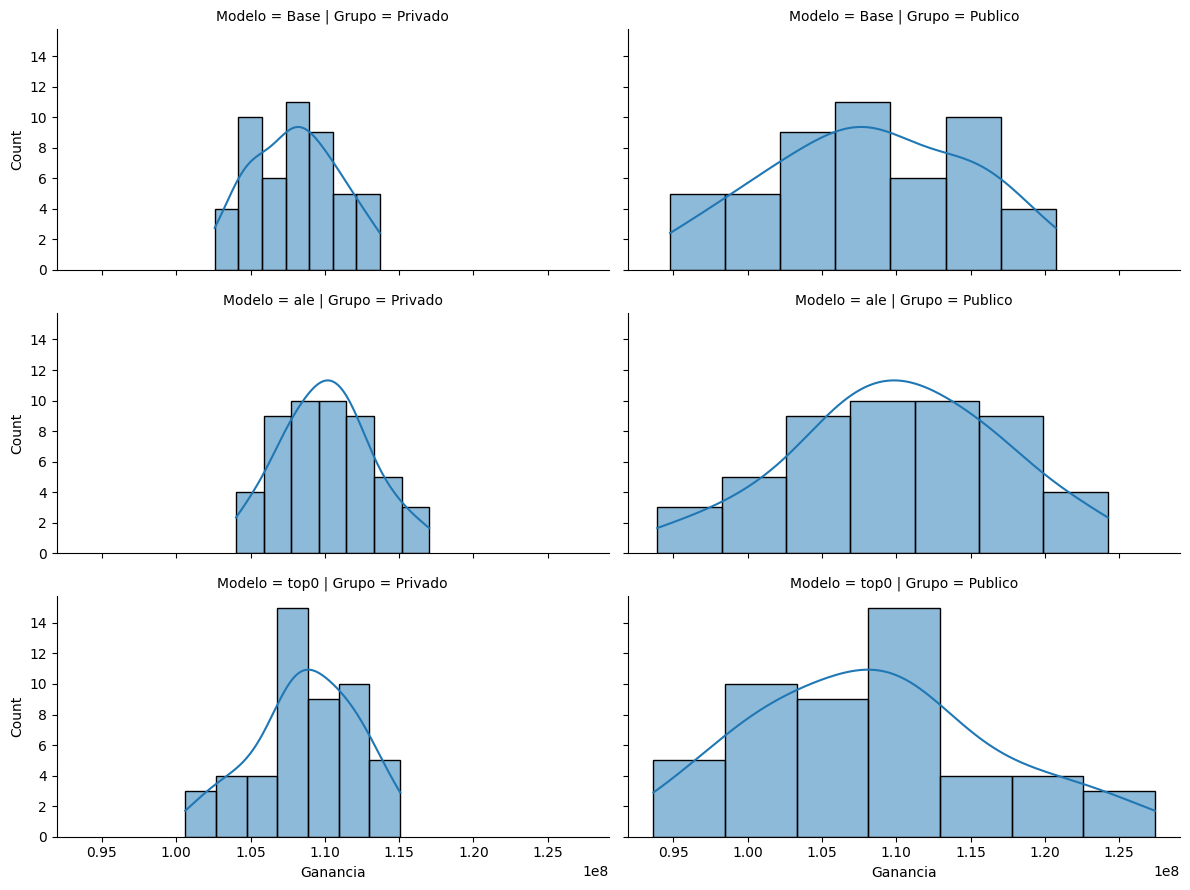

In [27]:
ganancias_futuro_top0_publica = []
ganancias_futuro_top0_privado = []
for train_index, test_index in sss_futuro.split(X_futuro, y_futuro):
  ganancias_futuro_top0_publica.append(ganancia(model_best, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3))
  ganancias_futuro_top0_privado.append(ganancia(model_best, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7))

df_pred_top0_privado = pd.DataFrame({'Ganancia': ganancias_futuro_top0_privado, 'Modelo': 'top0', 'Grupo': 'Privado'})
df_pred_top0_publica = pd.DataFrame({'Ganancia': ganancias_futuro_top0_publica, 'Modelo': 'top0', 'Grupo': 'Publico'})

df_combined = pd.concat([df_pred_1_base,
                         df_pred_2_base,
                         df_pred_1_ale,
                         df_pred_2_ale,
                         df_pred_top0_privado,
                         df_pred_top0_publica])

g = sns.FacetGrid(df_combined, col="Grupo", row="Modelo", aspect=2)
g.map(sns.histplot, "Ganancia", kde=True)
plt.show()

Bueno, no parece mucho mejor. Es tan solo mejor. Vamos moviendo de a poco la vara.

* ¿Qué se puede hacer para mejorarlo? Debate con la clase abierta

Una última cosa, solo de pura maldad...

In [36]:
intentos = study.get_trials()

In [47]:
top_trials_indices = study.trials_dataframe().sort_values(by='value', ascending=False).head(10).index.to_list()
top_trials = [intentos[i] for i in top_trials_indices]


In [51]:
n_top_models = 10
# top_trials = study.best_trials[0:n_top_models]

top_models = []
for i, trial in enumerate(top_trials):
     model_params = trial.params
     print(f"Top {i}: {model_params}")
     model = DecisionTreeClassifier(**model_params, random_state=semillas[0])
     model.fit(X, y)
     top_models.append(model)

ganancias_abril = []
for model in top_models:
  ganancias_abril.append(ganancia(model, X_futuro, y_futuro))

for i, ganancia_abril in enumerate(ganancias_abril):
  print(f"Ganancia de top {i} en abril: {ganancia_abril}")


Top 0: {'criterion': 'entropy', 'max_depth': 29, 'min_samples_split': 32, 'min_samples_leaf': 14, 'max_leaf_nodes': 58}
Top 1: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 14, 'max_leaf_nodes': 60}
Top 2: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 24, 'min_samples_leaf': 18, 'max_leaf_nodes': 40}
Top 3: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 19, 'max_leaf_nodes': 43}
Top 4: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 42, 'min_samples_leaf': 18, 'max_leaf_nodes': 36}
Top 5: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 42, 'min_samples_leaf': 18, 'max_leaf_nodes': 39}
Top 6: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 56, 'min_samples_leaf': 18, 'max_leaf_nodes': 41}
Top 7: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 26, 'min_samples_leaf': 18, 'max_leaf_nodes': 41}
Top 8: {'criterion': 'entropy', 'max_depth': 5

In [57]:
x_junio = data[data['foto_mes'] == 202106]
x_junio = x_junio.drop(columns=['clase_ternaria'])

In [58]:
# tomo modelo num 3 y reentreno en febrero
model_params = top_trials[2].params
model = DecisionTreeClassifier(**model_params, random_state=semillas[0])
model.fit(X, y)
y_hat = model.predict_proba(x_junio)

In [65]:
class_index = np.where(model.classes_ == "BAJA+2")[0][0]
y_pred = []
for prob in y_hat:
    # print(prob)
  if prob[class_index] > threshold:
    y_pred.append(True) 
  else:
    y_pred.append(False)

[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[0.00221924 0.00319016 0.9945906 ]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[0.02711223 0.03699033 0.93589744]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[0.00221924 0.00319016 0.9945906 ]
[2.79485746e-04 2.79485746e-04 9.99441029e-01]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[0.00221924 0.00319016 0.9945906 ]
[0.00101878 0.00120981 0.99777141]
[0.00221924 0.00319016 0.9945906 ]
[0.00221924 0.00319016 0.9945906 ]
[0.00221924 0.00319016 0.9945906 ]
[0.00221924 0.00319016 0.9945906 ]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[0.00221924 0.00319016 0.9945906 ]
[1.44538841e-04 1.76658583e-04 9.99678803e-01]
[0.00898509 0.01490709 0.97610782]
[0.         0.01408451 0.98591549]
[0.0467886  0.04721395 0.90599745]
[0.00221924 0.00319016 0.9945906 ]
[0.00221924 0.00319016 0.9945906 ]
[1.44

KeyboardInterrupt: 

## Tarea:

* Envíos a Kaggle:
 * Defina los mejores parámetros para realizar una búsqueda.
 * Explore la configuración de Optima para una mejor búsqueda.
 * Arme un script que tome la salida de un modelo y genere un archivo para Kaggle.
 * Entrena el modelo usando datos de febrero y mirando su rendimiento en abril.  
   * Prueba el modelo completo entrenado en febrero, score en Junio y suba a  Kaggle.
   * El modelo seleccionado se reentrena con los datos de abril y se scorea en junio para kaggle
* Busca el mejor modelo en abril y scoree en junio para Kaggle.

¿Cuál fue su mejor predicción?

Colaboración:
* Recuerde compartir con tus compañeros los nuevos scripts que hayas generado y las configuraciones que hayas probado por el canal de